# Local Retrieval-Augmented Generation (RAG) Basics


### What is Retrieval-Augmented Generation (RAG)?
RAG = Combine retrieval (finding relevant information) with generation (producing responses).
Useful for question-answering, creative text generation, etc.

# Retrieval

First, let's focus on the retrieval part 

## Embeddings Basics

We use sentence-transformer for our embeddings.  
Sentence Transformers (a.k.a. SBERT) is the go-to Python module for accessing, using, and training state-of-the-art embedding and reranker models.  
You can check it out here:  
https://www.sbert.net/index.html 

In [1]:
from sentence_transformers import SentenceTransformer

embeddings_model = SentenceTransformer('all-MiniLM-L6-v2') # a small general purpose model (80MB)
# this will download the model to your machine, might take a while when you run it for the first time

/Users/c/anaconda3/envs/bca/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next, let's define some sentences and encode them.
Encoding means that we convert our sentences into vectors (embeddings)

In [2]:
sentences = [
    "Ping me if you need anything.",
    "Let me know if you have any questions.",
    "this email thread was used to train a drone",
]

embedded_sentences = embeddings_model.encode(sentences)

When we print the shape of our embeddings we can see we have three sentences with 384 dimensions each

In [3]:
print(embedded_sentences.shape)

(3, 384)


with our embeddings ready, we can now compute the semantic similarity between all sentences.

In [4]:
similarities = embeddings_model.similarity(embedded_sentences, embedded_sentences)
print(similarities)

tensor([[1.0000, 0.4350, 0.1338],
        [0.4350, 1.0000, 0.1194],
        [0.1338, 0.1194, 1.0000]])


Let's visualize it

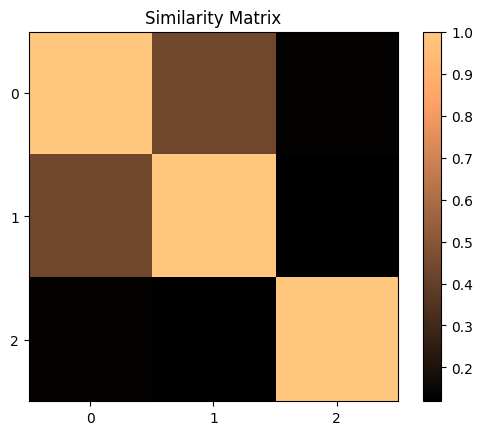

In [5]:
import matplotlib.pyplot as plt

plt.imshow(similarities, cmap="copper")
plt.colorbar()
plt.xticks(range(len(sentences)))
plt.yticks(range(len(sentences)))
plt.title("Similarity Matrix")
plt.show()

Each row and column corresponds to one sentence. The number at position [i, j] shows similarity between sentence i and sentence j.
As you can see sentence 0 and 1 are somwhat related but sentence 2 is not related to either of them. the diagonal line are the sentences being fully related to themselves.
Sentence 0 (“ping me”) and Sentence 1 (“let me know”) → Similarity 0.435 (related).
Sentence 0 and Sentence 2 (“train a drone”) → Similarity 0.1194 (unrelated).

## Chunking (splitting text)

Let's say we want to work with longer texts, it's a good idea to split or *chunk* it into smaller parts.

In [6]:
example_text = """
A measure of uncertainty of an outcome, rather than the perceived lack of order. 
A random sequence of events, symbols or steps often has no order and does not follow an intelligible pattern or combination. 
Randomness exists when some outcomes occur without any order, unpredictably, or by chance. 
These notions are distinct, but they all have a close connection to probability. 
Individual random events are unpredictable, but since they often follow a probability distribution, the frequency of different outcomes over numerous events (or “trials”) is predictable: 
when throwing two dice, the outcome of any particular roll is unpredictable, but a sum of 7 will occur twice as often as 4.
"""

We can write our own chunking functions, for example using a max character length per chunk:

In [7]:
def chunk_text_by_length(text, max_length):
    chunks = []
    current_chunk = ""

    for word in text.split():
        # Check if adding the next word exceeds the max length
        if len(current_chunk) + len(word) + 1 <= max_length:
            current_chunk += (word + " ")
        else:
            chunks.append(current_chunk.strip())
            current_chunk = word + " "
    
    if current_chunk:
        chunks.append(current_chunk.strip())
    
    return chunks

In [8]:
print(chunk_text_by_length(example_text, 50))

['A measure of uncertainty of an outcome, rather', 'than the perceived lack of order. A random', 'sequence of events, symbols or steps often has no', 'order and does not follow an intelligible pattern', 'or combination. Randomness exists when some', 'outcomes occur without any order, unpredictably,', 'or by chance. These notions are distinct, but', 'they all have a close connection to probability.', 'Individual random events are unpredictable, but', 'since they often follow a probability', 'distribution, the frequency of different outcomes', 'over numerous events (or “trials”) is', 'predictable: when throwing two dice, the outcome', 'of any particular roll is unpredictable, but a', 'sum of 7 will occur twice as often as 4.']


as you can see that might not be the best approach as a lot of meaning is getting lost between chunks.
Another approach could be to simply chunk by periods, so that we ideally end up with single sentences.

In [9]:
def chunk_text_by_period(text):
    sentences = text.split('.')
    chunks = []

    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:
            chunks.append(sentence + '.')

    return chunks

In [10]:
print(chunk_text_by_period(example_text))

['A measure of uncertainty of an outcome, rather than the perceived lack of order.', 'A random sequence of events, symbols or steps often has no order and does not follow an intelligible pattern or combination.', 'Randomness exists when some outcomes occur without any order, unpredictably, or by chance.', 'These notions are distinct, but they all have a close connection to probability.', 'Individual random events are unpredictable, but since they often follow a probability distribution, the frequency of different outcomes over numerous events (or “trials”) is predictable: \nwhen throwing two dice, the outcome of any particular roll is unpredictable, but a sum of 7 will occur twice as often as 4.']


this is already an improvement, however it can result in chunks of varying length. Also it might be good in many cases to have bigger chunks, what about paragraphs for example? since text can have so many forms, there is no one-size-fits-all solution.
There are some prewritten methods that you can use to chunk text that we will cover later.

In [11]:
# here add chunking functions

chunks = chunk_text_by_period(example_text)
print(chunks)

['A measure of uncertainty of an outcome, rather than the perceived lack of order.', 'A random sequence of events, symbols or steps often has no order and does not follow an intelligible pattern or combination.', 'Randomness exists when some outcomes occur without any order, unpredictably, or by chance.', 'These notions are distinct, but they all have a close connection to probability.', 'Individual random events are unpredictable, but since they often follow a probability distribution, the frequency of different outcomes over numerous events (or “trials”) is predictable: \nwhen throwing two dice, the outcome of any particular roll is unpredictable, but a sum of 7 will occur twice as often as 4.']


## Vector Databases (Chroma DB)

We use Chroma as a vector database. When working with a large number of embeddings it's a good idea to store them in a DB. Chroma is an open-source search and retrieval database that you can easily deploy locally.  
You can check it out here: https://www.trychroma.com/ 

In [12]:
import chromadb

# Create client and collection
client = chromadb.PersistentClient() # we use a persistent client to store our db 
# client.delete_collection(name="example_collection")
collection = client.create_collection("example_collection_rag")

embedded_chunks = embeddings_model.encode(chunks)

# Add embeddings manually
collection.add(
    embeddings=embedded_chunks,
    documents=chunks,
    ids=["chunk1", "chunk2", "chunk3", "chunk4", "chunk5"] # improve this
)

## Similarity Search 

In [14]:
query = "What is random?"
query_embedding = embeddings_model.encode(query)

results = collection.query(
    query_embeddings=[query_embedding],
    n_results=2
)

print("Results:", results)

Results: {'ids': [['chunk3', 'chunk5']], 'embeddings': None, 'documents': [['Randomness exists when some outcomes occur without any order, unpredictably, or by chance.', 'Individual random events are unpredictable, but since they often follow a probability distribution, the frequency of different outcomes over numerous events (or “trials”) is predictable: \nwhen throwing two dice, the outcome of any particular roll is unpredictable, but a sum of 7 will occur twice as often as 4.']], 'uris': None, 'included': ['metadatas', 'documents', 'distances'], 'data': None, 'metadatas': [[None, None]], 'distances': [[0.5814827084541321, 0.7597775459289551]]}


## Ollama 
Ollama is a local runtime to work with LLM's on you local machine. We'll use to simply download models and generate text based on our retrieved documents.  
Essentially it's a wrapper around https://github.com/ggml-org/llama.cpp but we'll stick with ollama for now since it's very easy to use.
You can download Ollama here: https://ollama.com/download  

If you run the GUI, it automatically serves all downloaded models on your PC

you can check which models you already downloaded with `ollama list`  

To run a model from your terminal, simply `ollama run` and select a model for example `ollama run gemma3:1b`  if you haven't downloaded it yet it will do so automatically.  

to stop chatting with a model, type `/bye`  

To use ollama in python, we need to `pip install ollama` to install the bindings.  
Then we can test it like this:

In [15]:
from ollama import chat
from ollama import ChatResponse

# the query we send to the LLM
query = "What is randomness?"

# this is the structure expected by the ollama API
response: ChatResponse = chat(model='gemma3:1b', messages=[
  {
    'role': 'user',
    'content': query,
  },
])

print(response['message']['content'])
# or access fields directly from the response object
print(response.message.content)

Okay, let's break down what randomness is. It's a fascinating and surprisingly complex concept, and it's something that has puzzled philosophers, mathematicians, and computer scientists for centuries. Here’s a breakdown of different perspectives on randomness:

**1. The Basic Definition:**

At its core, **randomness** refers to the *lack of predictable or regular patterns*.  It’s when a process produces results that seem unpredictable, even if they're generated by the same rules.

**2. Different Levels of Randomness:**

* **Statistical Randomness:** This is the most common understanding of randomness. It’s generated by algorithms that have a probability distribution.  Think of rolling dice, shuffling a deck of cards, or creating a random number sequence.  The output *appears* random because it’s based on probabilities, but it's fundamentally determined by the starting point and the algorithm.

* **True Randomness:** This is *much* harder to achieve and is what we really want in situati

## Connecting Retrieval and Generation

In [20]:
def query_rag(query, top_k=1):
    
    query_embedding = embeddings_model.encode(query)
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k
    )
    context = "\n".join(results['documents'][0])
    
    # Prompt the local Ollama model
    prompt = f"Using the following context, answer the question:\n\nContext:\n{context}\n\nQuestion:\n{query}\n"

    print(f"Prompt:\n{prompt}")
    
    response: ChatResponse = chat(
        model='gemma3:1b', 
        messages=[
            {
                'role': 'user',
                'content': prompt,
            },
        ]
        )
    return response.message.content

# Test query
query = "What is random?"
response = query_rag(query)

print(f"Response:\n{response}")

Prompt:
Using the following context, answer the question:

Context:
Randomness exists when some outcomes occur without any order, unpredictably, or by chance.

Question:
What is random?

Response:
According to the context, random means outcomes occur without any order, unpredictably, or by chance.


In [ ]:
# Next Steps: Parsing PDF & Using LangChain (covered later)
